# VIX-Adjusted Momentum (INDIA)

Replicating [VIX-Adjusted Momentum](https://cssanalytics.wordpress.com/2014/07/29/vix-adjusted-momentum/) using India VIX and the NIFTY 50 index.

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)

options(repr.plot.width=16, repr.plot.height=8)

indices <- Indices()

In [2]:
startDate <- as.Date('2009-03-03') #the day when India VIX was launched
endDate <- as.Date('2019-06-30')

vixDt <- indices$IndiaVixTimeSeries() %>%
    filter(TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))
    
nifty50Dt <- indices$NseTimeSeries() %>%
    filter(NAME == 'NIFTY 50' & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

In [3]:
doLookback <- function(lb){
    allXts <- na.locf(merge(xts(nifty50Dt$CLOSE, nifty50Dt$TIME_STAMP), xts(vixDt$CLOSE, vixDt$TIME_STAMP)))
    names(allXts) <- c('NIFTY', 'VIX')

    allXts$SMA <- SMA(allXts$NIFTY, lb)
    allXts$D_RET <- dailyReturn(allXts$NIFTY)
    allXts$D_RET_LAG_1 <- stats::lag(allXts$D_RET, -1) #signal is generated and traded at the close, so use next day's return

    allXts$VIX_ADJ_RET <- allXts$D_RET/allXts$VIX
    allXts$VIX_ADJ_RET_SMA <- SMA(allXts$VIX_ADJ_RET, lb) 

    allXts$ROC <- rollapply(allXts$D_RET, lb, Return.cumulative) #simple compound return or ROC (rate of change) 

    allXts <- na.omit(allXts)

    #go long only if the index is above its 200-day average
    allXts$SMA_STRAT <- ifelse(allXts$NIFTY > allXts$SMA, allXts$D_RET_LAG_1, 0) 

    #go long only if the simple average (VIX-Adjusted Momentum) > 0
    allXts$VIX_STRAT <- ifelse(allXts$VIX_ADJ_RET_SMA > 0, allXts$D_RET_LAG_1, 0) 

    #go long only if the ROC > 0
    allXts$ROC_STRAT <- ifelse(allXts$ROC > 0, allXts$D_RET_LAG_1, 0)

    #plot returns
    toPlot <- merge(allXts$VIX_STRAT, allXts$SMA_STRAT, allXts$ROC_STRAT, allXts$D_RET_LAG_1)
    Common.PlotCumReturns(toPlot, sprintf("Back-test for %d look-back", lb), "")

    #calculate annual returns

    byYearDf <- data.frame(T=0, VIX_MOM=0.0, SMA=0.0, ROC=0.0, BH=0.0)

    allYears <- unique(year(index(allXts)))
    for(yr in allYears){
        byYearDf <- rbind(byYearDf,
                        c(yr, as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'VIX_STRAT'])),
                            as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'SMA_STRAT'])),
                            as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'ROC_STRAT'])),
                            as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'D_RET_LAG_1']))))
    }

    byYearDf <- byYearDf[-1,]
    print(byYearDf)

    #plot annual returns

    ggplot(melt(byYearDf, id='T'), aes(x=T, y=value, fill=variable)) +
        theme_economist() +
        geom_bar(stat="identity", position=position_dodge()) +
        scale_x_continuous(labels=byYearDf$T, breaks=byYearDf$T) +
        geom_text_repel(aes(label= round(value, 2)), position = position_dodge(0.9)) +
        labs(x='', y='(%)', fill='', title=sprintf("Back-test for %d look-back", lb), subtitle="Annual Returns") +
        annotate("text", x=max(byYearDf$T), y=min(sapply(byYearDf[,-1], min, na.rm=T)), 
                 label = "@StockViz", hjust=1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)  
}    

      T     VIX_MOM         SMA           ROC         BH
2  2009  55.8542447  43.9585559  47.986996234  70.967373
3  2010  14.7814451  12.2552717   7.696151507  17.686633
4  2011 -10.8882121 -13.2163854 -12.244349088 -24.698746
5  2012  18.9921529  14.2197847  15.513872076  28.340972
6  2013   4.9486352   5.6801427  12.472286384   5.894956
7  2014  24.3835287  22.4421699  28.362309580  31.457634
8  2015  -3.2570417  -4.0997036  -5.207613606  -3.872525
9  2016   0.6787297  -0.5741594   0.002138574   2.716245
10 2017  20.1963265  21.0425942  20.432594648  27.581759
11 2018   6.0377957  10.2504119   7.939196687   4.547436
12 2019  -1.6522020   1.2877901  -0.750851842   8.054463


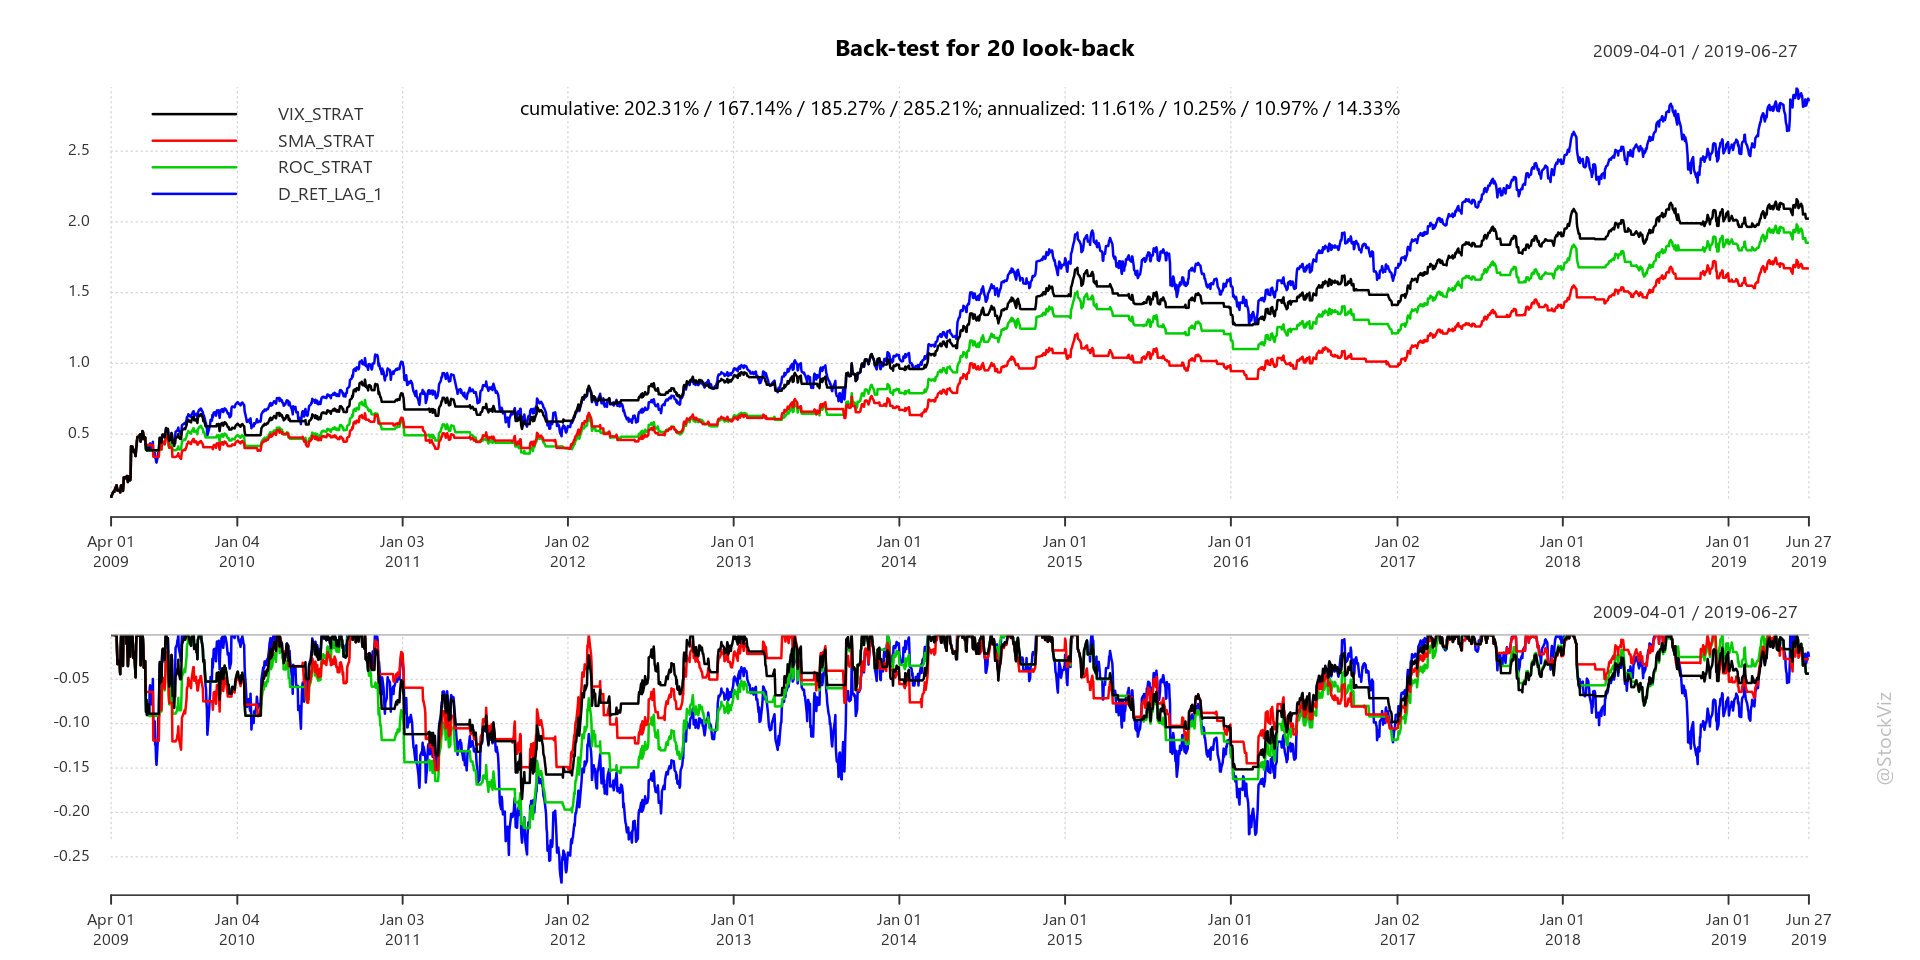

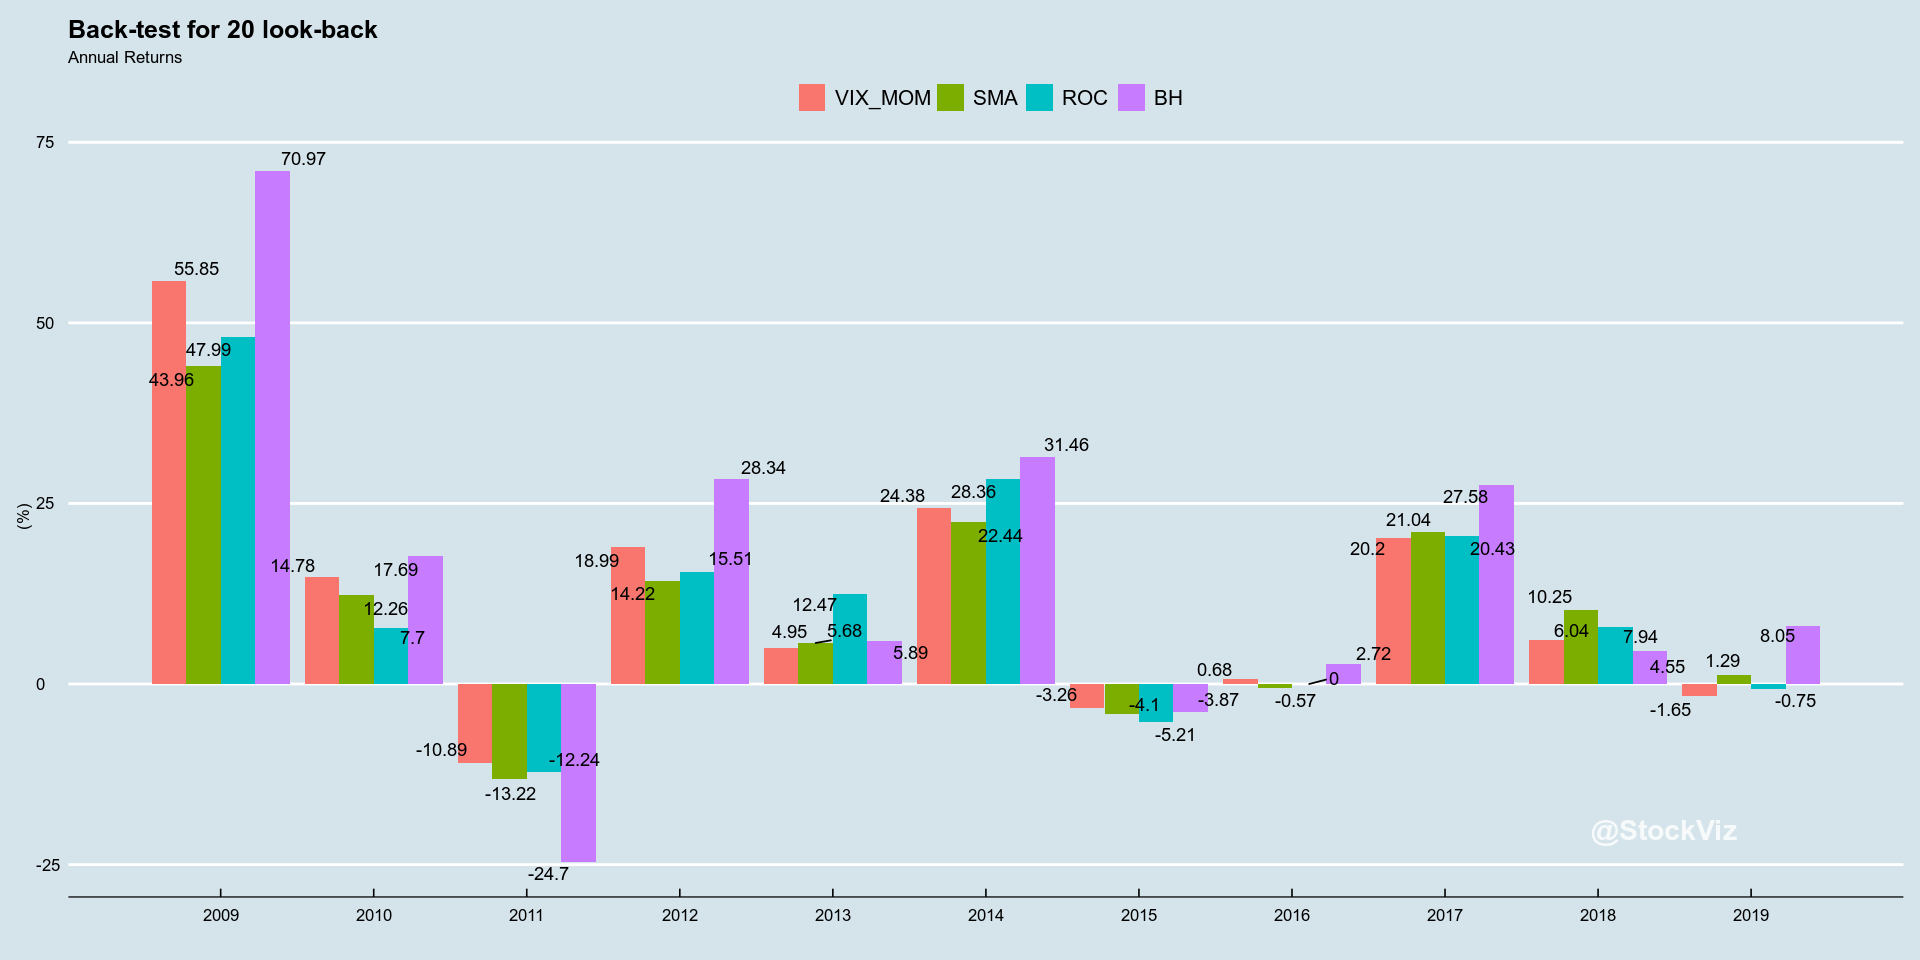

      T     VIX_MOM        SMA        ROC         BH
2  2009  19.5403008  2.9235720  17.122735  24.253722
3  2010  -0.8853483 16.9658616  -2.258700  17.686633
4  2011 -22.0712387 -6.9516003 -13.994246 -24.698746
5  2012  16.1229491 11.4475629  15.132554  28.340972
6  2013   1.0933239  3.5381681  -4.194506   5.894956
7  2014  24.5973807 20.6776846  24.688502  31.457634
8  2015  -6.2343550 -9.9562368  -9.921087  -3.872525
9  2016   6.9716624 10.1811402   9.549754   2.716245
10 2017  21.9358306 17.8671136  20.404191  27.581759
11 2018  -3.2803592  6.0710868   1.296014   4.547436
12 2019   6.2768668  0.6400177   6.210951   8.054463


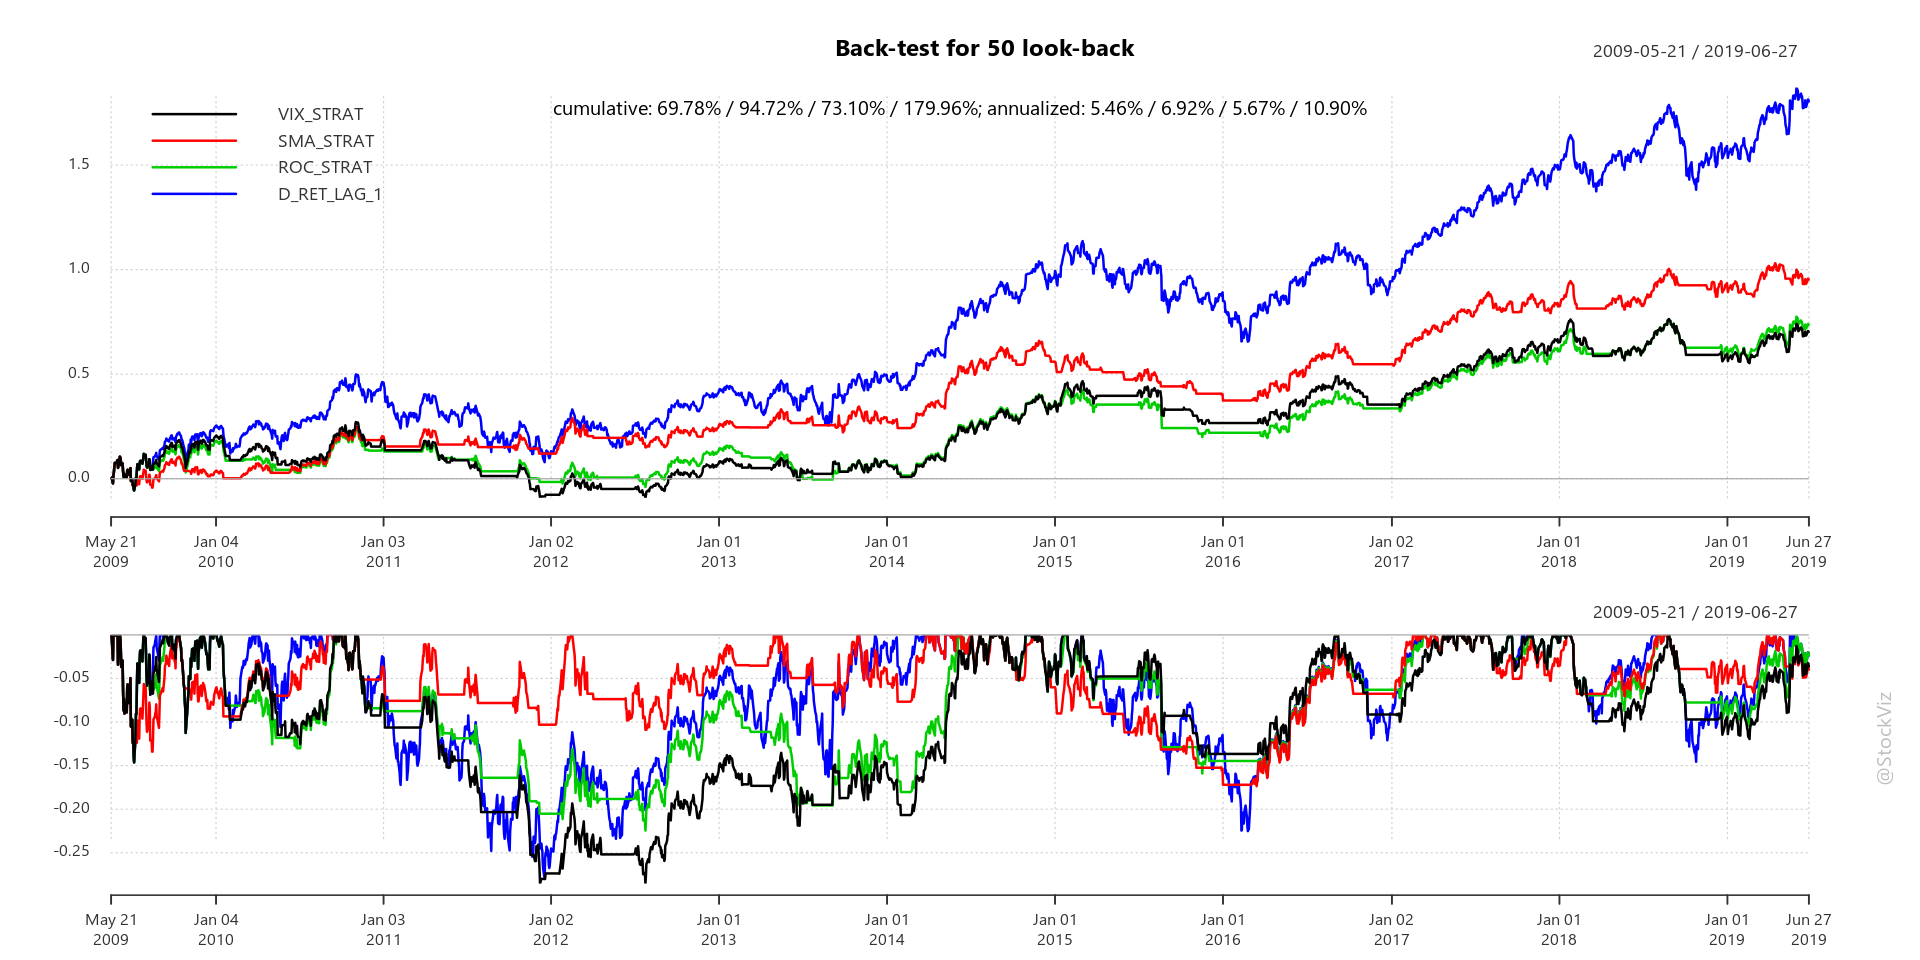

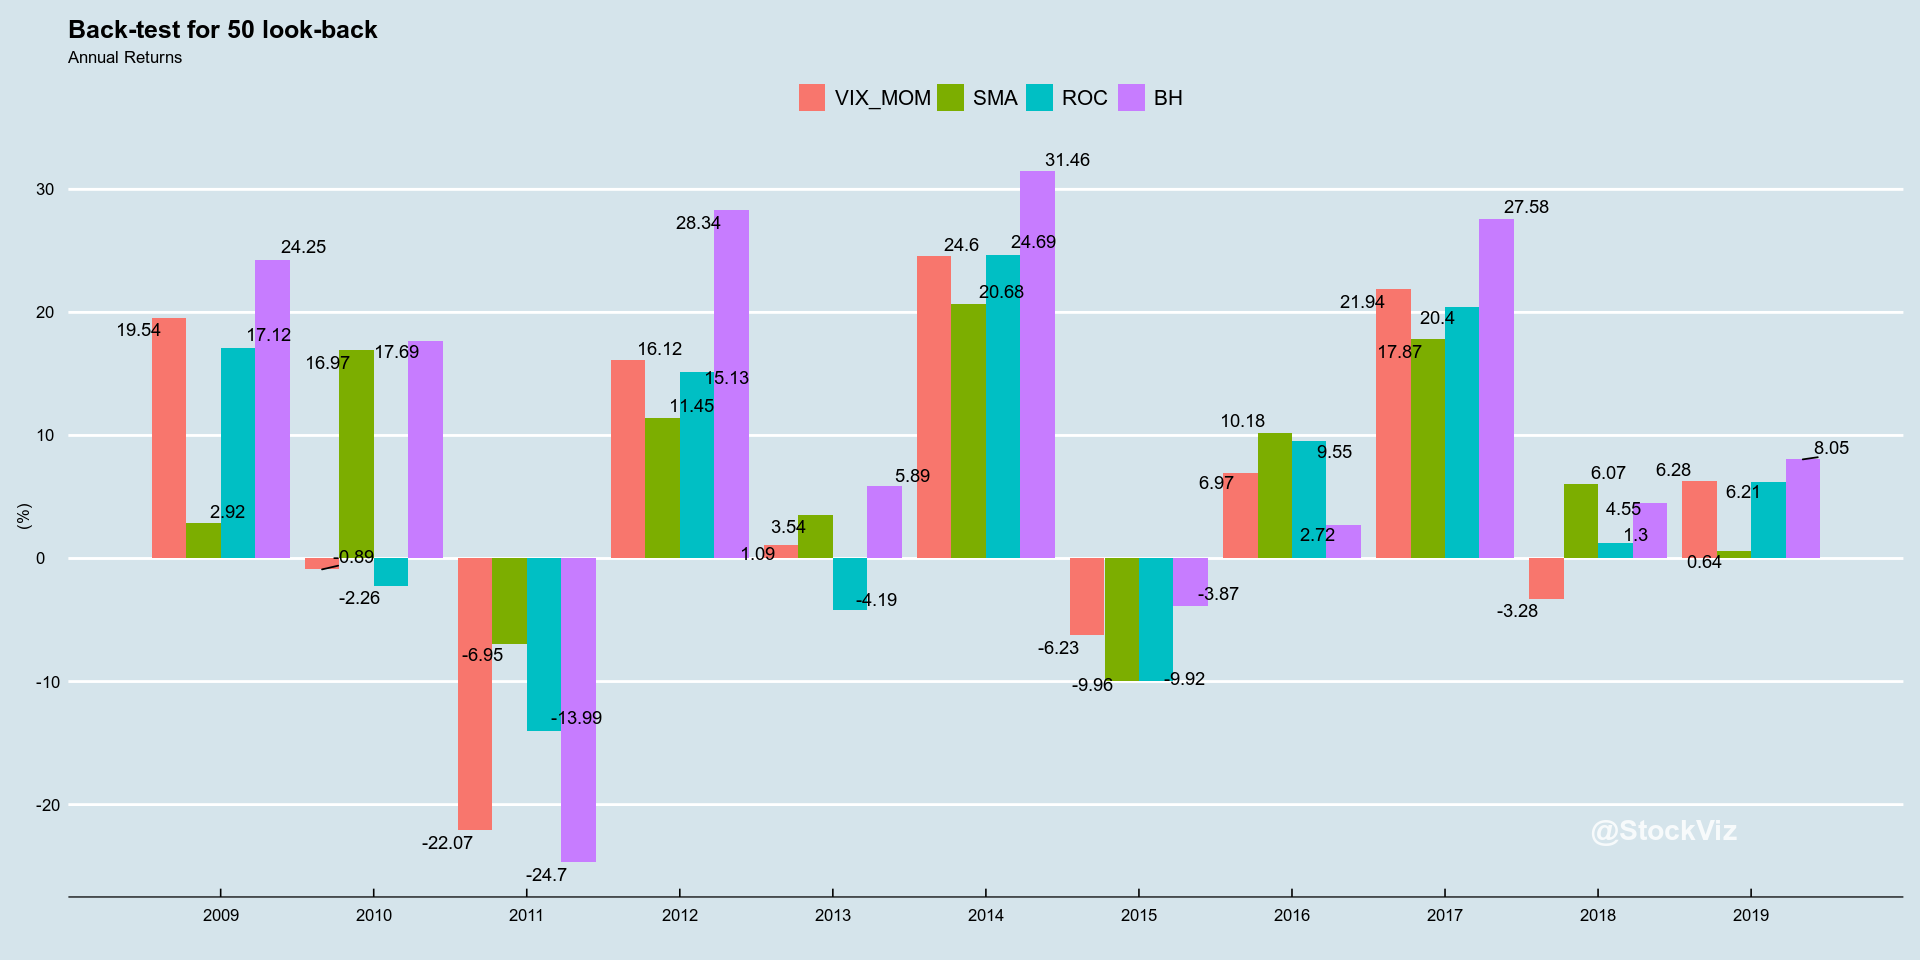

      T    VIX_MOM         SMA        ROC         BH
2  2009  14.453838  10.8847486  14.453838  14.453838
3  2010   3.074059   6.2265444  -2.693106  17.686633
4  2011 -17.124885 -13.1193054 -11.971114 -24.698746
5  2012  20.259606  13.6248986  10.471499  28.340972
6  2013   2.314944  -7.0322024  -6.741117   5.894956
7  2014  31.457634  26.7188666  32.232468  31.457634
8  2015 -12.607978  -7.9263826  -5.779633  -3.872525
9  2016   4.235006   8.7104640   2.805273   2.716245
10 2017  19.418980  19.7503868  16.912948  27.581759
11 2018  -6.710956  -0.6823267  -5.747986   4.547436
12 2019   8.017013   5.6815172   9.088848   8.054463


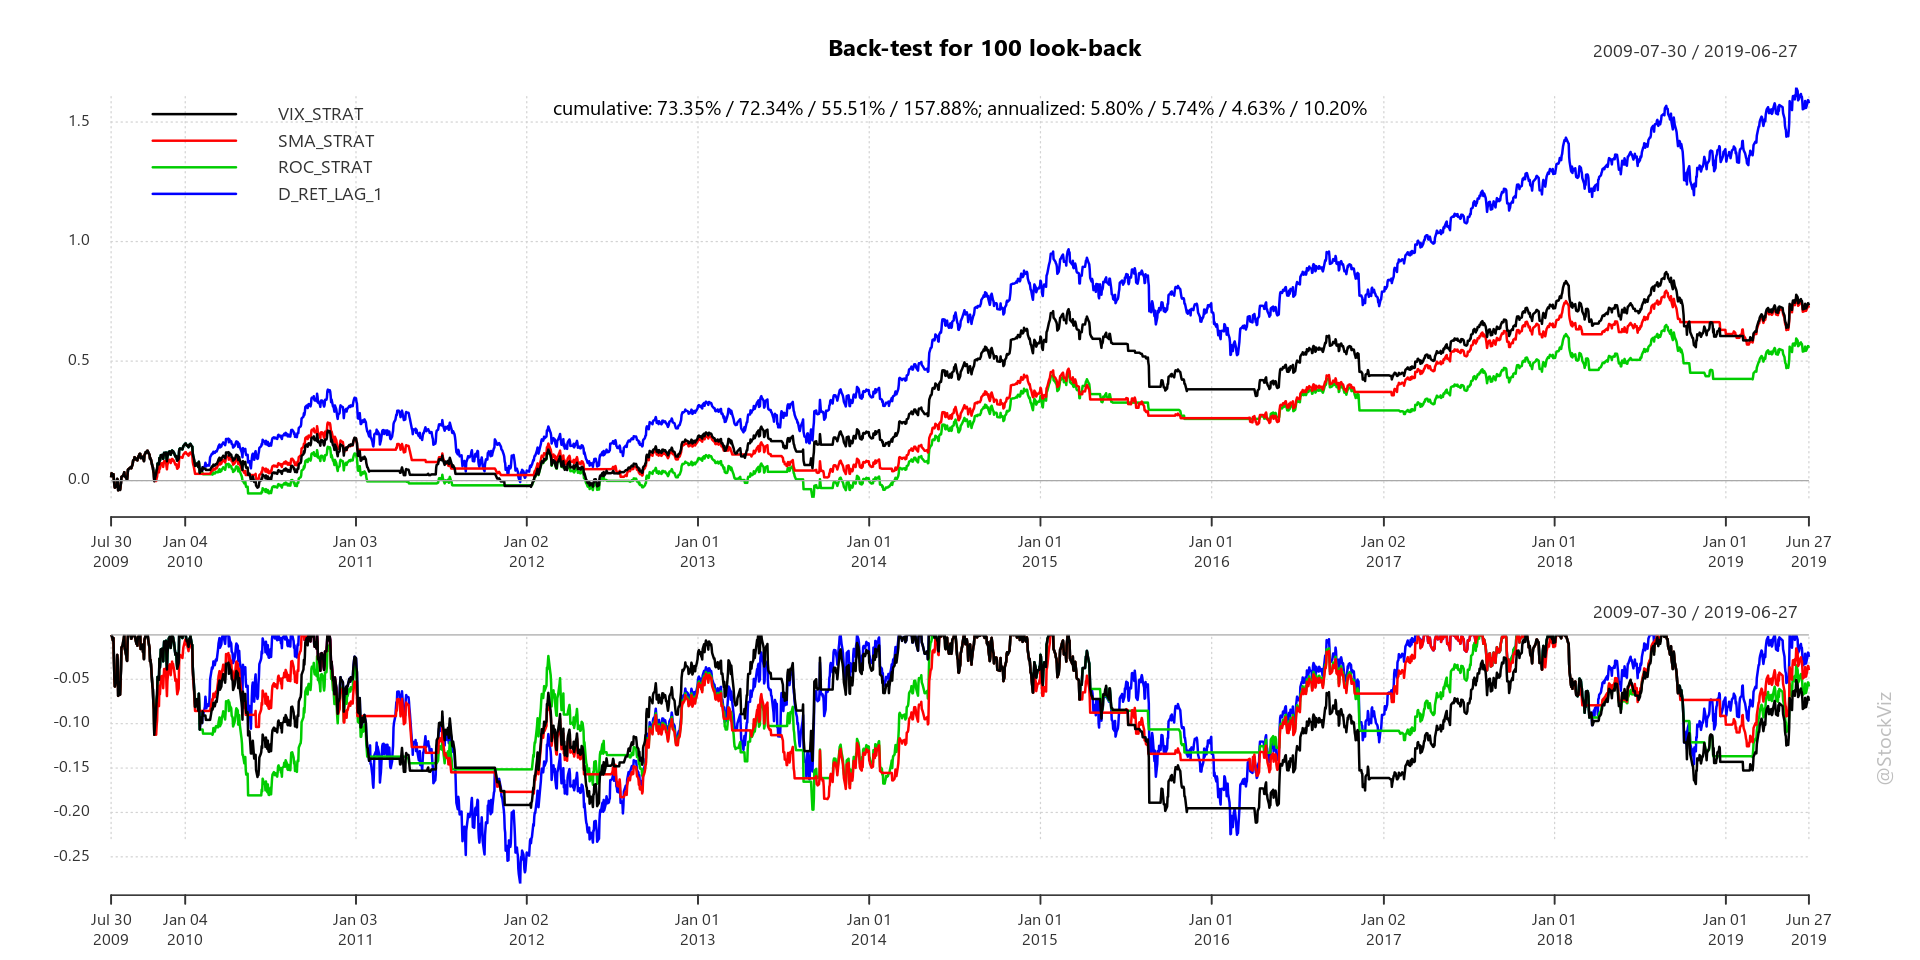

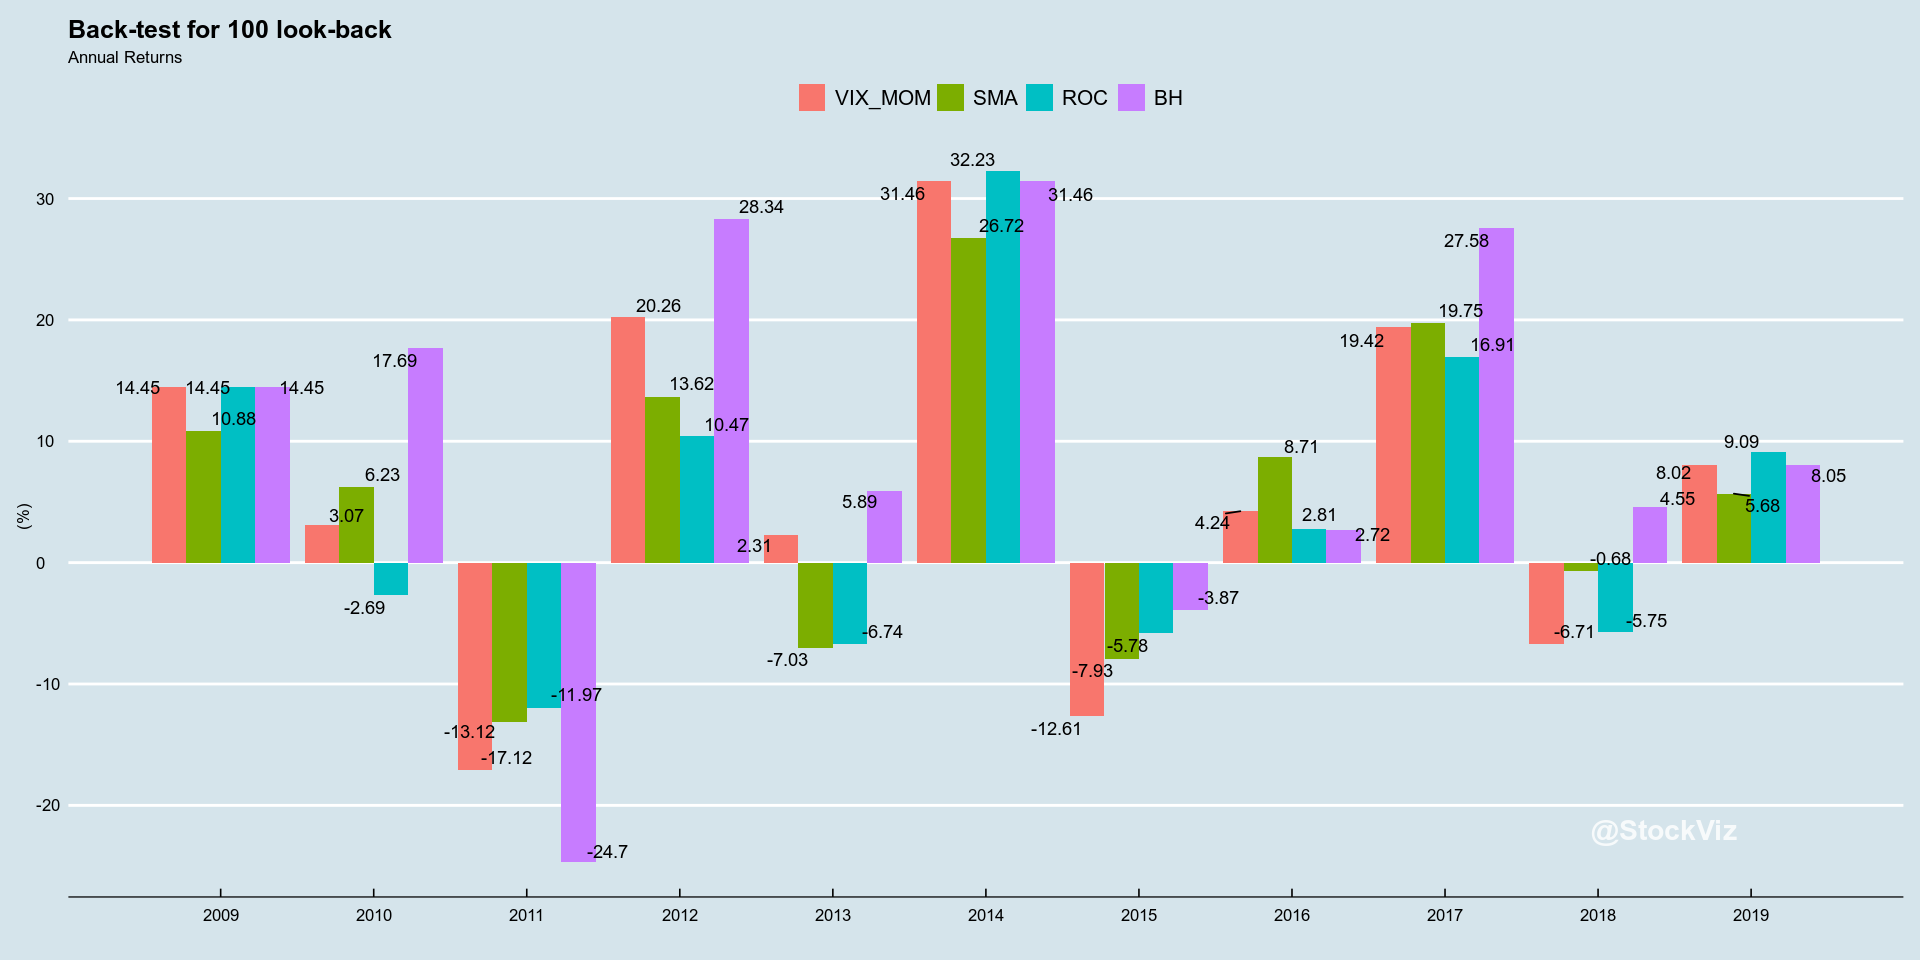

      T    VIX_MOM        SMA         ROC         BH
2  2009   1.038931   1.038931   1.0389309   1.038931
3  2010  17.686633  12.514723  17.6866328  17.686633
4  2011 -12.349590  -9.541756 -14.9335901 -24.698746
5  2012  13.931431   7.418435  12.9133781  28.340972
6  2013   3.514348  -6.066451  -5.5739313   5.894956
7  2014  31.457634  31.457634  31.4576341  31.457634
8  2015  -6.347899 -15.667298  -1.7263752  -3.872525
9  2016   3.257257  -4.675845   0.1138283   2.716245
10 2017  27.581759  25.902444  27.5817593  27.581759
11 2018   4.547436  -4.655957  -3.6968017   4.547436
12 2019   8.054463   3.840349   5.5301819   8.054463


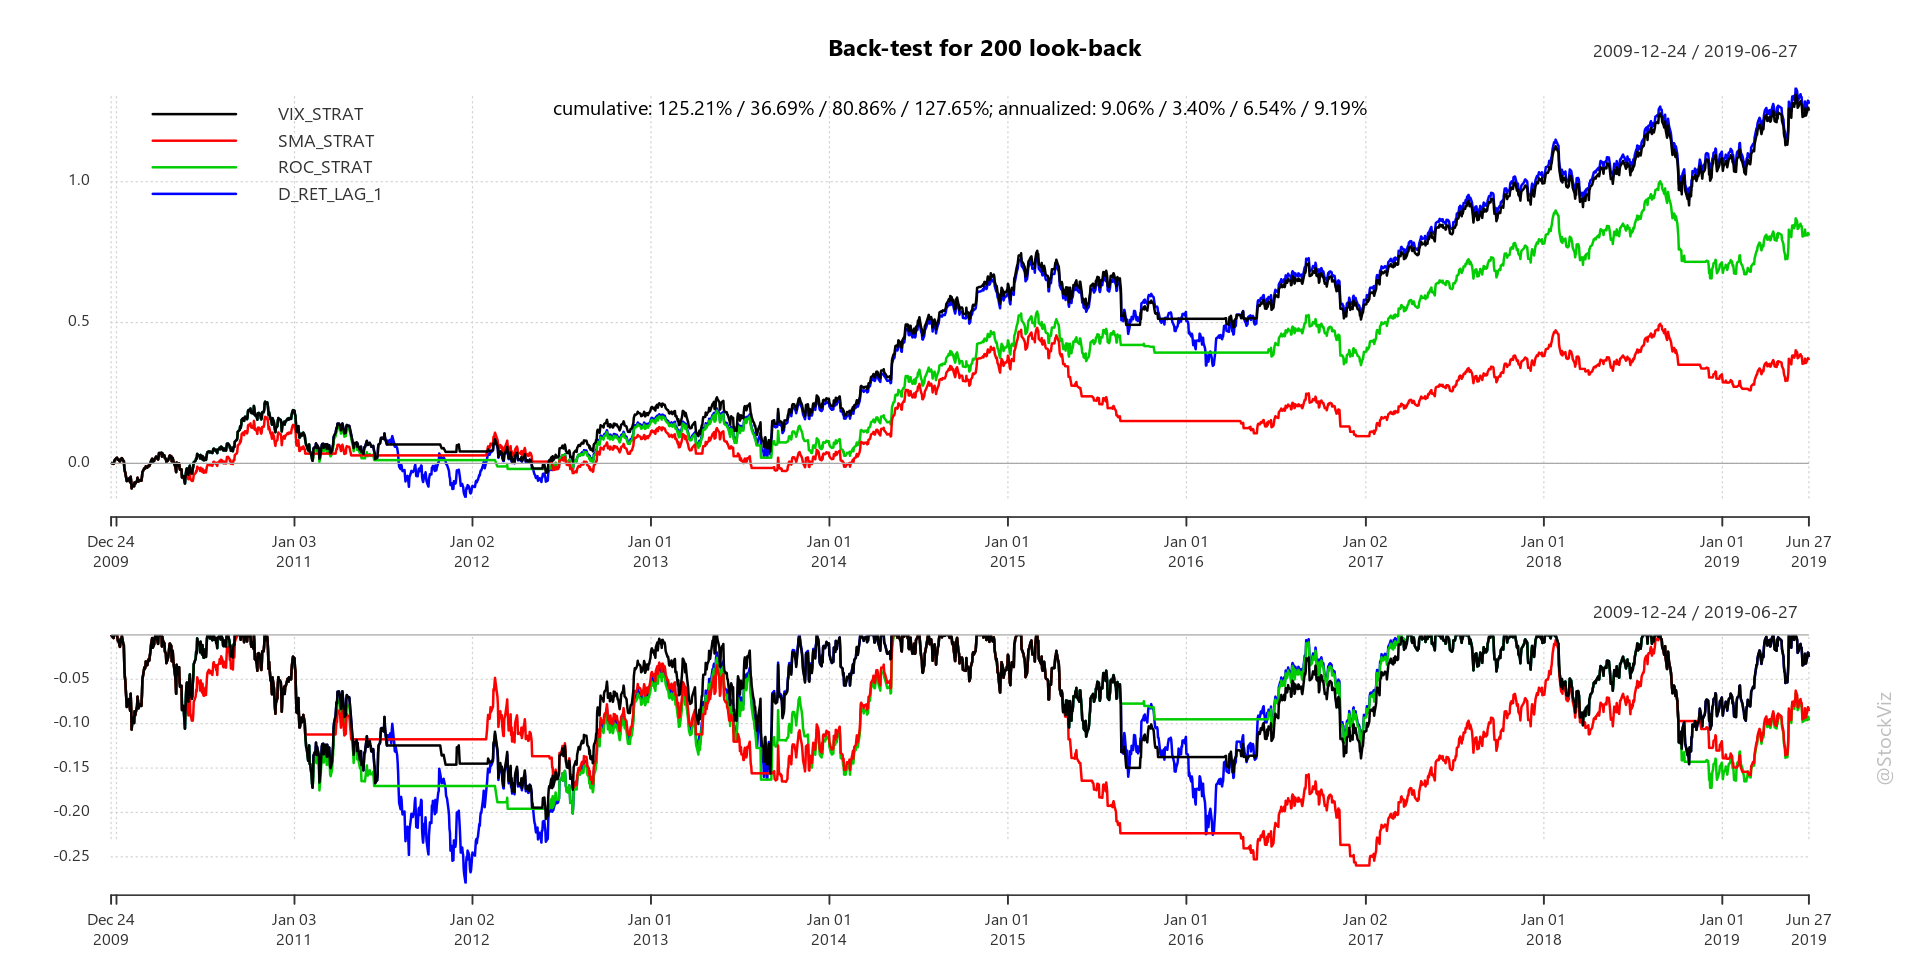

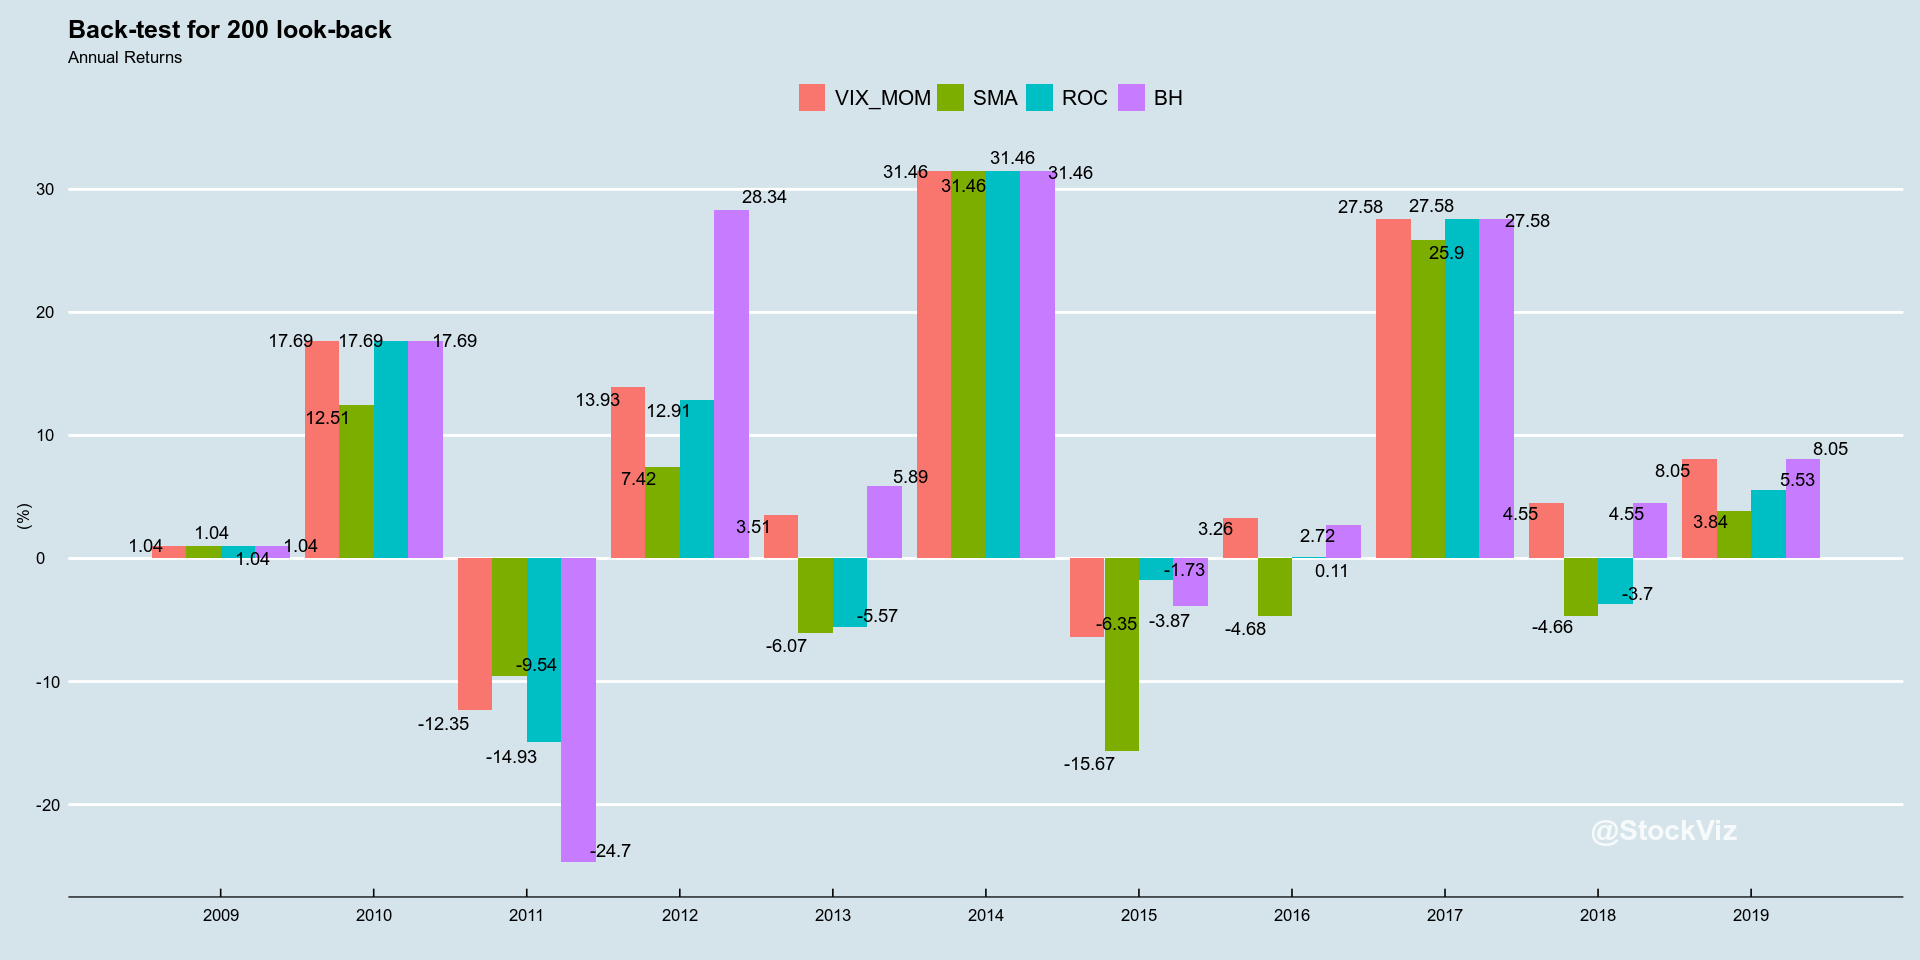

In [4]:
doLookback(20)
doLookback(50)
doLookback(100)
doLookback(200)

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)